In [19]:
import tensorflow as tf   
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random 
import os

In [21]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
import keras_tuner as kt

In [22]:
SEED = 0

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_global_determinism(seed=SEED)

In [23]:
model = tf.keras.models.load_model("models/LSTM_county")


In [39]:
model = tf.keras.models.load_model("models\LSTM_county_r")

In [40]:
df = pd.read_csv("datasets\covid19vaccinesbycountybydemographic.csv")

df = df[df['demographic_category'].str.contains("Race/Ethnicity")]

df['demographic_category'].unique()

array(['Race/Ethnicity'], dtype=object)

In [41]:
df['demographic_value'].unique()

array(['American Indian or Alaska Native', 'Asian',
       'Black or African American', 'Latino', 'Multiracial',
       'Native Hawaiian or Other Pacific Islander', 'Other Race',
       'Unknown', 'White'], dtype=object)

In [42]:
df = df[~df['demographic_value'].str.contains("Other Race|Unknown")]

df['demographic_value'].unique()

array(['American Indian or Alaska Native', 'Asian',
       'Black or African American', 'Latino', 'Multiracial',
       'Native Hawaiian or Other Pacific Islander', 'White'], dtype=object)

In [43]:
encoder = LabelEncoder()
df['county_encoded'] = encoder.fit_transform(df['county'])
df['demographic_encoded'] = encoder.fit_transform(df['demographic_value'])

In [44]:
df['percent_fully_vaccinated'] = df['cumulative_fully_vaccinated'] / df['est_population']

df = df[df['percent_fully_vaccinated'] != 0]
df = df[df['percent_fully_vaccinated'].notnull()]
df['percent_fully_vaccinated'] = df['percent_fully_vaccinated'].clip(upper=1)

In [45]:
df['administered_date'] = pd.to_datetime(df['administered_date'], format = '%Y-%m-%d')

df['time_since_start'] = (df['administered_date'] - df['administered_date'].min()).dt.days

In [46]:
prep_df = df[['percent_fully_vaccinated', 'county_encoded', 'demographic_encoded', 'time_since_start']]

prep_df = prep_df[prep_df['percent_fully_vaccinated'] != 0]
prep_df = prep_df[prep_df['percent_fully_vaccinated'].notnull()]


prep_df

,percent_fully_vaccinated,county_encoded,demographic_encoded,time_since_start
24240,1.000000,0,0,1465
24241,1.000000,0,0,1464
24242,1.000000,0,0,1463
24243,1.000000,0,0,1462
24244,1.000000,0,0,1461
...,...,...,...,...
2179837,0.000025,58,6,20
2179838,0.000025,58,6,19
2179839,0.000025,58,6,18
2179840,0.000025,58,6,17


In [47]:
time_step = 10

grouped_county = prep_df.groupby(['county_encoded', 'demographic_encoded'])

X = []
y = []

for name, group in grouped_county:
    values = group[['percent_fully_vaccinated', 'county_encoded', 'demographic_encoded', 'time_since_start']].values

    for i in range(len(values) - time_step):
        X.append(values[i:i+time_step,:])
        y.append(values[i+time_step, 0])

X = np.array(X)
y = np.array(y)

In [48]:
encoded_county = list(zip(df['county_encoded'].unique(), df['county'].unique()))

sorted(encoded_county, key=lambda x: x[0])

[(0, 'Alameda'),
 (1, 'Alpine'),
 (2, 'Amador'),
 (3, 'Butte'),
 (4, 'Calaveras'),
 (5, 'Colusa'),
 (6, 'Contra Costa'),
 (7, 'Del Norte'),
 (8, 'El Dorado'),
 (9, 'Fresno'),
 (10, 'Glenn'),
 (11, 'Humboldt'),
 (12, 'Imperial'),
 (13, 'Inyo'),
 (14, 'Kern'),
 (15, 'Kings'),
 (16, 'Lake'),
 (17, 'Lassen'),
 (18, 'Los Angeles'),
 (19, 'Madera'),
 (20, 'Marin'),
 (21, 'Mariposa'),
 (22, 'Mendocino'),
 (23, 'Merced'),
 (24, 'Modoc'),
 (25, 'Mono'),
 (26, 'Monterey'),
 (27, 'Napa'),
 (28, 'Nevada'),
 (29, 'Orange'),
 (30, 'Placer'),
 (31, 'Plumas'),
 (32, 'Riverside'),
 (33, 'Sacramento'),
 (34, 'San Benito'),
 (35, 'San Bernardino'),
 (36, 'San Diego'),
 (37, 'San Francisco'),
 (38, 'San Joaquin'),
 (39, 'San Luis Obispo'),
 (40, 'San Mateo'),
 (41, 'Santa Barbara'),
 (42, 'Santa Clara'),
 (43, 'Santa Cruz'),
 (44, 'Shasta'),
 (45, 'Sierra'),
 (46, 'Siskiyou'),
 (47, 'Solano'),
 (48, 'Sonoma'),
 (49, 'Stanislaus'),
 (50, 'Statewide'),
 (51, 'Sutter'),
 (52, 'Tehama'),
 (53, 'Trinity'),
 (5

In [49]:
encoded_ethnicity = list(zip(df['demographic_value'].unique(), df['demographic_encoded'].unique()))

sorted(encoded_ethnicity, key=lambda x: x[0])

[('American Indian or Alaska Native', 0),
 ('Asian', 1),
 ('Black or African American', 2),
 ('Latino', 3),
 ('Multiracial', 4),
 ('Native Hawaiian or Other Pacific Islander', 5),
 ('White', 6)]

In [52]:
def forecast(data, prep_df, county_encode, ethnicity_encode, forecast_days, model): 
    df = data[(data['county_encoded'] == county_encode) & (data['demographic_encoded'] == ethnicity_encode)]
    df = df.reset_index(drop=True)

    prep_df = prep_df[(prep_df['county_encoded'] == county_encode) & (prep_df['demographic_encoded'] == ethnicity_encode)]
    prep_df = prep_df.reset_index(drop = True)
    prep_df = prep_df[:10].iloc[::-1]

    forecast_array = prep_df.values
    forecast_array = forecast_array.reshape((1,10,4))
    
    predictions = []

    for i in range(forecast_days):
        next_prediction = model.predict(forecast_array)
        next_prediction = next_prediction.reshape((1,1,1))

        increment_day = forecast_array[0, -1, 3] + 1

        next_input = np.array([[[next_prediction[0,0,0], forecast_array[0,-1,1], forecast_array[0,-1,2], increment_day]]])

        forecast_array = np.append(forecast_array[:,1:,:], next_input, axis = 1)

        predictions.append(next_prediction[0,0,0])

    predictions = np.array(predictions)

    last_date = df['administered_date'].max()

    next_month = pd.date_range(start = last_date, periods = forecast_days+1)

    next_month = next_month[1:]

    # index = df[df['administered_date'] == "2022-01-01"].index
    index = df['administered_date'].idxmin()

    
    past_df = df[:index]

    past_df = past_df[['administered_date', 'percent_fully_vaccinated']]

    predictions_df = pd.DataFrame({'administered_date': next_month,
                                  'percent_fully_vaccinated': predictions})
    


    plt.figure(figsize=(14, 7))
    plt.plot(past_df['administered_date'], past_df['percent_fully_vaccinated'], color = 'r', marker = 'o')
    plt.plot(predictions_df['administered_date'], predictions_df['percent_fully_vaccinated'], color = 'b', marker = 'o')
    plt.xticks(rotation = 45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    

1/1 [==============================] - 0s 11ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


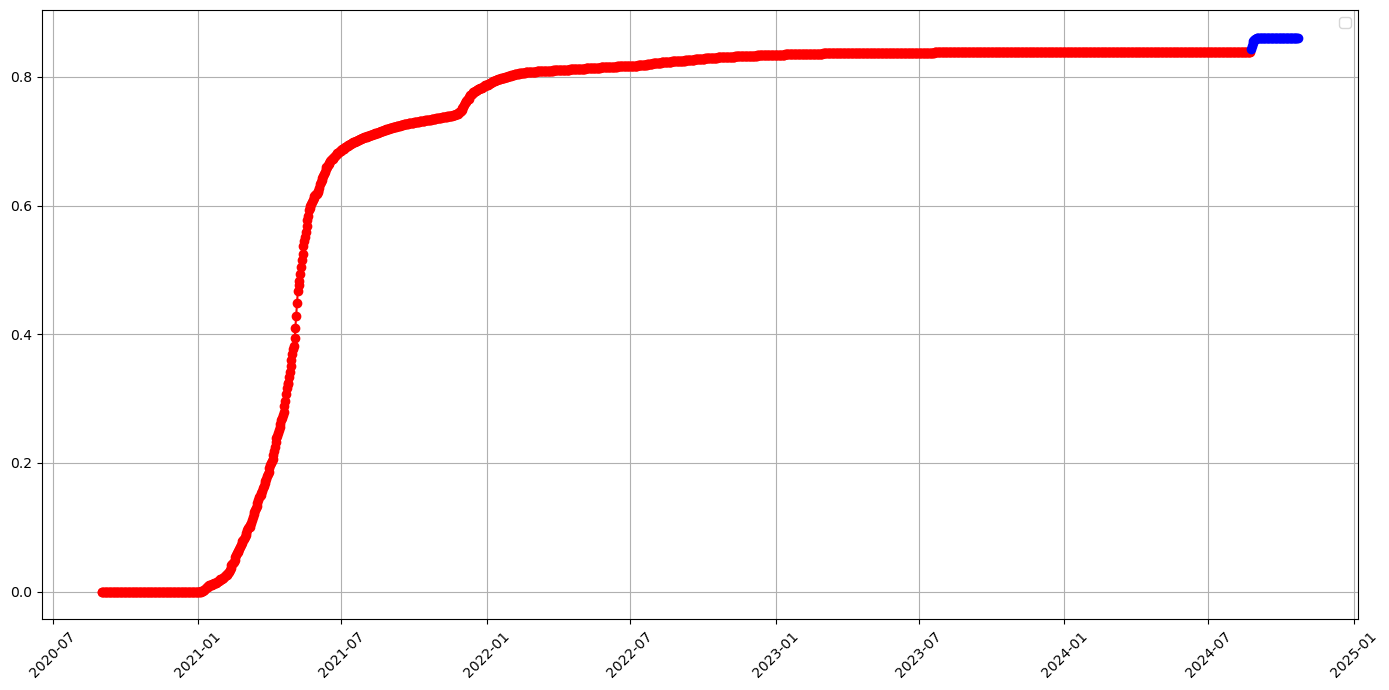

In [53]:
#Santa Clara and Asian - 30 days forecast

forecast(df,prep_df,  42, 1, 60, model)